In [1]:
###########################
# Imports
###########################
import sys

import matplotlib.pyplot as plt
import numpy as np

from simulation.elements.Element import Element
from simulation.elements.MeltSlicedElement import MeltSlicedElement
from simulation.exchanges.Exchange import Exchange
from simulation.exchanges.SolidExchange import SolidExchange
from simulation.models.Model import Model

from threading import Thread

%matplotlib inline

###########################
#  Définition des grandeurs
###########################

simulation_time = 3600 * 100 # s

# Béton
hauteur_beton_sacrificiel = 0.5  # metres
surface_beton = 99
temperature_intiale_beton = 70 + 273  # K
conductivite_beton = 1.9082
temperature_fusion_beton = 1500  # K
chaleur_latente_beton = 640000  # J/kg
masse_beton = 100000
capacite_thermique_beton = 1430
volume_beton = hauteur_beton_sacrificiel * surface_beton
masse_volumique_beton = masse_beton / volume_beton

# Air
temperature_initiale_air = 1450 + 273  # ° kelvins
masse_air = 1000  # kg
capacite_thermique_air = 1100
conductivite_air = 0.08
masse_volumique_air = 1.2  # kg/m^3
hauteur_air = masse_air / masse_volumique_air / surface_beton

# Corium
coefficient_echange_air_corium = 5  # W/(m2.K)
masse_volumique_corium = 4600  # kg/m^3
volume_corium = 59  # m^3
masse_corium = 271e3
capacite_thermique_corium = lambda t: 1000 if t <= 1700 else (1700 if t <= 2200 else 800)
#conductivite_corium = lambda t: 0.001 * t + 1 if t <= 1600 else (0.001 * t + 1 if t <= 2000 else 0.0067 * t - 10.333)
conductivite_corium = lambda t: 0.000875 * (t - 1200) + 2.3 if t <= 2000 else 0.0066666667*(t-2000)+3
hauteur_corium = masse_corium / masse_volumique_corium / surface_beton

temperature_initiale_corium = 2273
#production_chaleur_corium = 35e6

T0 = 365  # jours de fonctionnement du réacteur avant incident
production_chaleur_corium = lambda time, T=None: 6.48e-3 * 4500e6 * ((time / (3600 * 24)) ** -0.2 - ((time / (3600 * 24)) + T0) ** -0.2)


# Acier
temperature_initiale_acier = 343
temperature_fusion_acier = 1500
masse_volumique_acier = 8000
conductivite_thermique_acier = 50
capacite_thermique_acier = 470
surface_acier = 2.4
epaisseur_acier = 0.04
volume_acier = surface_acier * epaisseur_acier
masse_acier = masse_volumique_acier * volume_acier

In [2]:
def run_simulation(nombre_couches, timestep=10):
    model = Model([
        Element(temperature_initiale_air, masse_volumique_air, 3, capacite_thermique_air, surface_beton,
                conductivite_air),
        Exchange(h=5 * 99, radiations=False, prev_temp_radiation=1500),
        Element(temperature_initiale_corium, masse_volumique_corium, volume_corium / surface_beton,
                capacite_thermique_corium, surface_beton, conductivite_corium, production_chaleur_corium),
        SolidExchange(radiations=False),
        MeltSlicedElement(temperature_intiale_beton, masse_volumique_beton,
                          hauteur_beton_sacrificiel, surface_beton,
                          capacite_thermique_beton, conductivite_beton, nombre_couches, temperature_fusion_beton,
                          chaleur_latente_beton,
                          0),
        SolidExchange(radiations=False),
        Element(temperature_initiale_acier, masse_volumique_acier, epaisseur_acier, capacite_thermique_acier,
                surface_acier, conductivite_thermique_acier, 0)
    ])

    time = model.run(
        timestep=timestep, time=simulation_time,
        time_offset=0,
        early_interrupt=lambda s: s.layers[-1].T > temperature_fusion_acier + 150
    )

    return np.argmax(np.array(model.layers[-1].history["T"]) > temperature_fusion_acier) * timestep

In [3]:
mem = {}

In [8]:
couches_a_tester = []
couches_a_tester += [i for i in range(1, 10)] + [10 * i for i in range(1, 10)] + [20 * i + 100 for i in range(1, 20)]
couches_a_tester += [15, 100]

for n in couches_a_tester:
    mem[n] = run_simulation(n)
    

  9% (3555 of 36000) |#                  | Elapsed Time: 0:00:07 ETA:   0:01:25

Text(0.5, 1.0, 'Temps de rétention du corium dans le puit de cuve\nen fonction du nombre de couches de béton')

<Figure size 720x360 with 0 Axes>

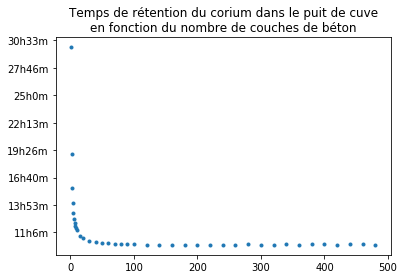

In [23]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

plt.figure(figsize=(10, 5))
#plt.xscale("log")
#plt.yscale("log")

fig, ax = plt.subplots()

def format_fn(tick_val, tick_pos):
    return "{}h{}m".format(int(tick_val / 3600), int((tick_val % 3600) / 60))

ax.plot(mem.keys(), mem.values(), ".")
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
plt.title("Temps de rétention du corium dans le puit de cuve\nen fonction du nombre de couches de béton")

In [6]:
#mem_t = {}
#temps_a_tester = [0.1, 0.5, 1, 5, 10, 30, 60, 90, 120]
#temps_a_tester = [10 * i for i in range(2, 12)]

for t in temps_a_tester:
    mem_t[t] = run_simulation(100, t)

NameError: name 'temps_a_tester' is not defined

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xscale("log")
#plt.yscale("log")
plt.plot(mem_t.keys(), mem_t.values(), "o")
plt.title("Temps que met corium à supprimer le béton sacrificiel en fonction du pas de temps")